In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import damask

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())
damask3_template_path = "damask3/damask3_template"

The current directory is: 
c:\Users\nguye\Desktop\Crystal-Plasticity-COE-Journal\damask3
Moving up to the parent directory
c:\Users\nguye\Desktop\Crystal-Plasticity-COE-Journal


In [5]:
###################################
# Preprocessing nonlinear loading #
###################################
import math
def preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ):
    strainPathXprocess = strainPathX.copy()
    strainPathYprocess = strainPathY.copy()
    strainPathZprocess = strainPathZ.copy()
    turningIndices = turningStressPoints(trueStress)
    #print(turningIndices)
    #unloadingIndex = turningIndices[0]
    reloadingIndex = turningIndices[1]
    #print(trueStress[reloadingIndex - 1])
    #print(trueStress[reloadingIndex])
    #print(trueStress[reloadingIndex + 1])
    for i in range(reloadingIndex, trueStrain.size):
        strainPathXprocess[i] -= strainPathX[reloadingIndex]
        strainPathYprocess[i] -= strainPathY[reloadingIndex]
        strainPathZprocess[i] -= strainPathZ[reloadingIndex]
    #strainReloading =  (2 ** (1/2))/3 * (strainPathXprocess ** 2 + strainPathYprocess ** 2 + strainPathZprocess ** 2) ** (1/2) + trueStrain[reloadingIndex]
    strainReloading =  (2/3) ** (1/2) * (strainPathXprocess ** 2 + strainPathYprocess ** 2 + strainPathZprocess ** 2) ** (1/2) + trueStrain[reloadingIndex]
    actualStrain = trueStrain.copy()
    for i in range(reloadingIndex, trueStrain.size):
        actualStrain[i] = strainReloading[i]
    return {"strain": actualStrain, "stress": trueStress}

def turningStressPoints(trueStress):
    differences = np.diff(trueStress)
    index = 1
    turningIndices = []
    while index < differences.size:
        if (differences[index - 1] <= 0 and differences[index] >= 0) or (differences[index - 1] >= 0 and differences[index] <= 0):
            turningIndices.append(index)
        index += 1
    return turningIndices

def preprocessDAMASKNonlinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))","1_ln(V)","5_ln(V)","9_ln(V)"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    strainPathX = df["1_ln(V)"].to_numpy().reshape(-1)
    strainPathY = df["5_ln(V)"].to_numpy().reshape(-1)
    strainPathZ = df["9_ln(V)"].to_numpy().reshape(-1)
    return preprocessNonlinear(trueStrain, trueStress, strainPathX, strainPathY, strainPathZ)

################################
# Preprocessing linear loading #
################################

def preprocessLinear(trueStrain, trueStress):
    # truePlasticStrain = trueStrain - trueElasticstrain = trueStrain - trueStress/Young's modulus
    Young = (trueStress[1] - trueStress[0]) / (trueStrain[1] - trueStrain[0])
    truePlasticStrain = trueStrain - trueStress / Young    
    return {"strain": truePlasticStrain, "stress": trueStress}

def preprocessDAMASKLinear(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy().reshape(-1)
    trueStress = df["Mises(Cauchy)"].to_numpy().reshape(-1)
    return preprocessLinear(trueStrain, trueStress)   

##############################
# Obtain the original curves #
##############################

def preprocessDAMASKTrue(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    trueStrain = df["Mises(ln(V))"].to_numpy()
    trueStress = df["Mises(Cauchy)"].to_numpy()
    return {"strain": trueStrain, "stress": trueStress}
    
def preprocessAverage(path, excel=False):
    if not excel:
        df = pd.read_csv(path, skiprows = 6, delimiter = "\t")
    else:
        df = pd.read_excel(path, usecols=["Mises(Cauchy)","Mises(ln(V))"], skiprows=6, engine="openpyxl")
    columnsStrain = []
    columnsStress = []
    for i in range (1, 10):
        columnsStrain.append(f"{i}_ln(V)")
        columnsStress.append(f"{i}_Cauchy")
        
    trueStrain = df[columnsStrain].mean(axis=1).to_numpy()
    trueStress = df[columnsStress].mean(axis=1).to_numpy()
    return {"strain": trueStrain, "stress": trueStress}

def Mises(what,tensor):
    
  dev = tensor - np.trace(tensor)/3.0*np.eye(3)
  symdev = 0.5*(dev+dev.T)
  return math.sqrt(np.sum(symdev*symdev.T)*
        {
         'stress': 3.0/2.0,
         'strain': 2.0/3.0,
         }[what.lower()])


In [ ]:
loading = "linear_uniaxial_RD"

In [8]:
resultPH = damask.Result(f'damask3/sidebyside/PH_{loading}/RVE_1_40_D_tensionX.hdf5')

# https://damask.mpie.de/documentation/examples/add_field_data.html
# add deformation gradient rate F and Piola–Kirchhoff stress P

resultPH.add_stress_Cauchy()
resultPH.add_strain()


# Add the Mises equivalent of the Cauchy stress 'sigma'
# Add the Mises equivalent of the spatial logarithmic strain 'epsilon_V^0.0(F)'
resultPH.add_equivalent_Mises('sigma')
resultPH.add_equivalent_Mises('epsilon_V^0.0(F)')

resultPH.view(increments=0)

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


Created by /projappl/project_2004956/damask3/grid_solver/bin/DAMASK_grid v3.0.0-alpha6
        on 2023-02-13 00:26:13+0200
 executing "/projappl/project_2004956/damask3/grid_solver/bin/DAMASK_grid --load tensionX.yaml --geom RVE_1_40_D.vti"

increment_0 (0.0 s)
  phase
    Aluminum
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        F_p / 1: plastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / q_0 (q_1 q_2 q_3): crystal orientation as quaternion
        P / Pa: first Piola-Kirchhoff stress
        epsilon_V^0.0(F) / 1: strain tensor of F (deformation gradient)
        epsilon_V^0.0(F)_vM / 1: Mises equivalent strain of epsilon_V^0.0(F) (strain tensor of F (deformation gradient))
        gamma_sl / 1: plastic shear
        sigma / Pa: Cauchy stress calculated from P (first Piola-Kirchhoff stress) and F (deformation gradient)
        sigma_vM / Pa: Mises equivalent stress of sigma (Cauchy stress calcu

### Linear uniaxial RD

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


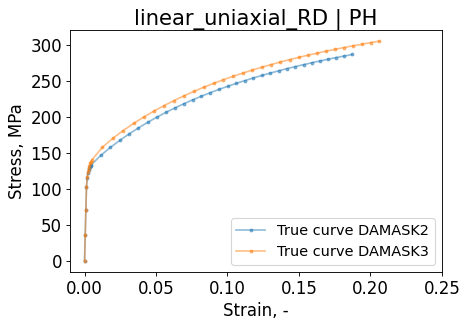

In [9]:
trueStress3 = np.array([np.average(s) for s in resultPH.get('sigma_vM').values()])
trueStress3 *= 1e-6
trueStrain3 = np.array([np.average(e) for e in resultPH.get("epsilon_V^0.0(F)_vM").values()])
##trueStrain3 = np.array([np.average(e) for e in result.get('epsilon_V^0.0(F)_vM').values()])
#print(result.get("epsilon_V^0.0(F)").values())
#print(trueStrain3)
path = f"damask3/sidebyside/PH_{loading}/RVE_1_40_D_tensionX.txt"

if loading != "linear_uniaxial_RD":
    trueStrain2, trueStress2 = preprocessDAMASKTrue(path).values()
    #trueStrain2, trueStress2 = preprocessAverage(path).values()
    trueStress2 *= 1e-6
    #processStrain, processStress = preprocessDAMASKNonlinear(path).values()
    #processStress *= 1e-6
else:
    trueStrain2, trueStress2 = preprocessDAMASKTrue(path).values()
    #trueStrain2, trueStress2 = preprocessAverage(path).values()
    trueStress2 *= 1e-6
    #processStrain, processStress = preprocessDAMASKLinear(path).values()
    #processStress *= 1e-6

size = 15

figure(figsize=(6, 4), dpi=80)
plt.plot(trueStrain2, trueStress2, alpha = 0.5, label = f"True curve DAMASK2", marker='.', markersize=5)
plt.plot(trueStrain3, trueStress3, alpha = 0.5, label = f"True curve DAMASK3", marker='.', markersize=5)

plt.title(f"{loading} | PH", size=size + 4)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
plt.legend(loc=4, fontsize=size - 2)

In [6]:
loading = "linear_uniaxial_RD"

resultDB = damask.Result(f'damask3/sidebyside/DB_{loading}/RVE_1_40_D_tensionX.hdf5')

# https://damask.mpie.de/documentation/examples/add_field_data.html
# add deformation gradient rate F and Piola–Kirchhoff stress P

resultDB.add_stress_Cauchy()
resultDB.add_strain()

# Add the Mises equivalent of the Cauchy stress 'sigma'
# Add the Mises equivalent of the spatial logarithmic strain 'epsilon_V^0.0(F)'
resultDB.add_equivalent_Mises('epsilon_V^0.0(F)')
resultDB.add_equivalent_Mises('sigma')

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


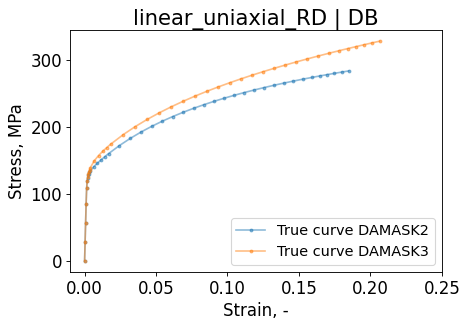

In [7]:
size = 15

yieldingPoint = 0.006


trueStress3 = np.array([np.average(s) for s in resultDB.get('sigma_vM').values()])
trueStress3 *= 1e-6
trueStrain3 = np.array([np.average(e) for e in resultDB.get("epsilon_V^0.0(F)_vM").values()])

path = f"damask3/sidebyside/DB_{loading}/RVE_1_40_D_tensionX.txt"

if loading != "linear_uniaxial_RD":
    trueStrain2, trueStress2 = preprocessDAMASKTrue(path).values()
    #trueStrain2, trueStress2 = preprocessAverage(path).values()
    trueStress2 *= 1e-6
    #processStrain, processStress = preprocessDAMASKNonlinear(path).values()
    #processStress *= 1e-6
else:
    trueStrain2, trueStress2 = preprocessDAMASKTrue(path).values()
    #trueStrain2, trueStress2 = preprocessAverage(path).values()
    trueStress2 *= 1e-6
    #processStrain, processStress = preprocessDAMASKLinear(path).values()
    #processStress *= 1e-6


figure(figsize=(6, 4), dpi=80)
plt.plot(trueStrain2, trueStress2, alpha = 0.5, label = f"True curve DAMASK2", marker='.', markersize=5)
plt.plot(trueStrain3, trueStress3, alpha = 0.5, label = f"True curve DAMASK3", marker='.', markersize=5)
plt.title(f"{loading} | DB", size=size + 4)
plt.rc('xtick', labelsize=size)    
plt.rc('ytick', labelsize=size)  
plt.xticks(fontsize=size)
plt.yticks(fontsize=size)
plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.ylabel('Stress, MPa', size=size)
plt.xlabel("Strain, -", size=size)
plt.legend(loc=4, fontsize=size - 2)